In [97]:
import numpy as np
import random 
import gym

import tensorflow as tf
#tf.enable_eager_execution()
import numpy as np
import pandas as pd

from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

In [98]:
# enable eager execution
tf.enable_eager_execution()

In [99]:
# seed random number generators for reproducable results
np.random.seed (0)
random.seed(0)
tf.set_random_seed(0)
#tf.random.set_seed(0)

# SAMPLE DATA

In [100]:
# for details see: https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py
CART_POS="cartPos"
CART_VEL="cartVel"
PEND_POS="pendPos"
PEND_VEL="pendVel"
EPISODE="episode"
STEP="step"
ACTION="action"
    
def sample_data (episodes=10000, seed=0):
    env = gym.make ("CartPole-v1")
    env.np_random.seed(0)
    
    ### CREATE EMPTY Pandas dataset
    transitions = []

    ### SAMPLE DATA
    for episode in range (episodes):
        #print ("Start of episode %d" % episode)
        obs = env.reset()
        step = 0
        done = False

        while step < 500 and not done:
            step += 1
            action = env.action_space.sample()

            transitions.append({CART_POS:obs[0], CART_VEL:obs[1], 
                             PEND_POS:obs[2], PEND_VEL:obs[3],
                             EPISODE:episode, STEP:step, ACTION:action})

            obs, reward, done, _ = env.step(action)

        #print ("  --> finished after %d steps" % step)
        
    return pd.DataFrame(transitions)


df = sample_data(episodes=200, seed=0)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

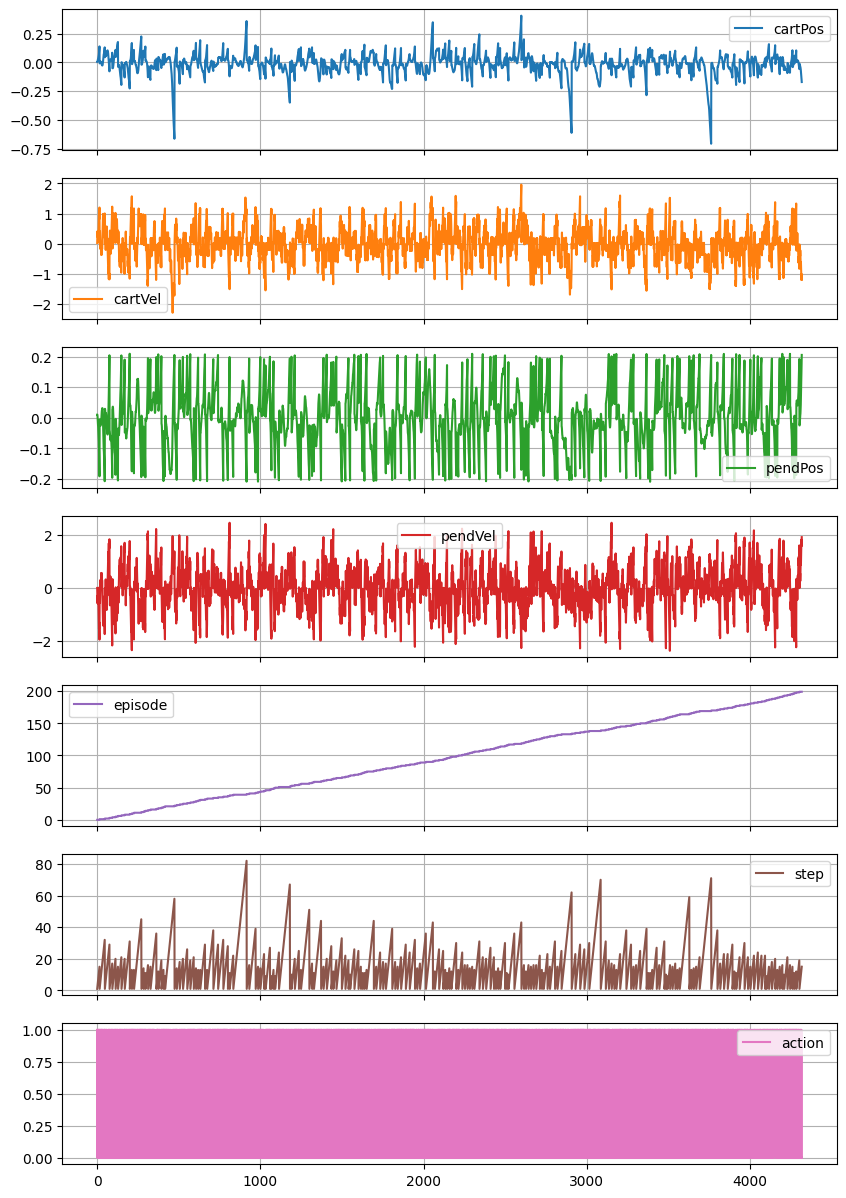

In [101]:
df.plot(subplots=True, figsize=(10,15), grid=True)

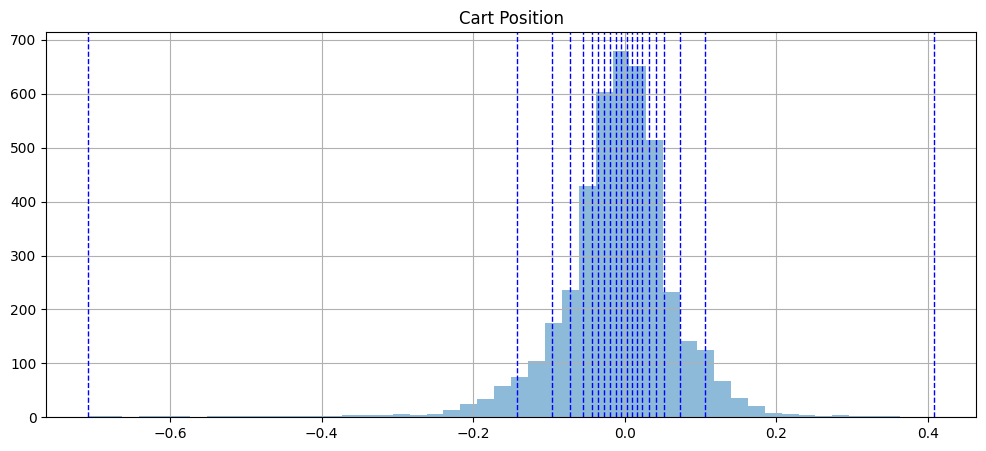

In [102]:
plt.figure(figsize=(12,5))
plt.hist(df[CART_POS], bins=50, alpha=0.5, label=CART_POS)

# add quantiles
plt.axvline(df[CART_POS].quantile(0.0), color='b', linestyle='dashed', linewidth=1, label="0%")
plt.axvline(df[CART_POS].quantile(0.05), color='b', linestyle='dashed', linewidth=1, label="5%")
plt.axvline(df[CART_POS].quantile(0.10), color='b', linestyle='dashed', linewidth=1, label="10%")
plt.axvline(df[CART_POS].quantile(0.15), color='b', linestyle='dashed', linewidth=1, label="15%")
plt.axvline(df[CART_POS].quantile(0.20), color='b', linestyle='dashed', linewidth=1, label="20%")
plt.axvline(df[CART_POS].quantile(0.25), color='b', linestyle='dashed', linewidth=1, label="25%")
plt.axvline(df[CART_POS].quantile(0.30), color='b', linestyle='dashed', linewidth=1, label="30%")
plt.axvline(df[CART_POS].quantile(0.35), color='b', linestyle='dashed', linewidth=1, label="35%")
plt.axvline(df[CART_POS].quantile(0.40), color='b', linestyle='dashed', linewidth=1, label="40%")
plt.axvline(df[CART_POS].quantile(0.45), color='b', linestyle='dashed', linewidth=1, label="45%")
plt.axvline(df[CART_POS].quantile(0.50), color='b', linestyle='dashed', linewidth=1, label="50%")
plt.axvline(df[CART_POS].quantile(0.55), color='b', linestyle='dashed', linewidth=1, label="55%")
plt.axvline(df[CART_POS].quantile(0.60), color='b', linestyle='dashed', linewidth=1, label="60%")
plt.axvline(df[CART_POS].quantile(0.65), color='b', linestyle='dashed', linewidth=1, label="65%")
plt.axvline(df[CART_POS].quantile(0.70), color='b', linestyle='dashed', linewidth=1, label="70%")
plt.axvline(df[CART_POS].quantile(0.75), color='b', linestyle='dashed', linewidth=1, label="75%")
plt.axvline(df[CART_POS].quantile(0.80), color='b', linestyle='dashed', linewidth=1, label="80%")
plt.axvline(df[CART_POS].quantile(0.85), color='b', linestyle='dashed', linewidth=1, label="85%")
plt.axvline(df[CART_POS].quantile(0.90), color='b', linestyle='dashed', linewidth=1, label="90%")
plt.axvline(df[CART_POS].quantile(0.95), color='b', linestyle='dashed', linewidth=1, label="95%")
plt.axvline(df[CART_POS].quantile(1.0), color='b', linestyle='dashed', linewidth=1, label="100%")



plt.grid()
# plt.legend()
plt.title("Cart Position")
plt.show()

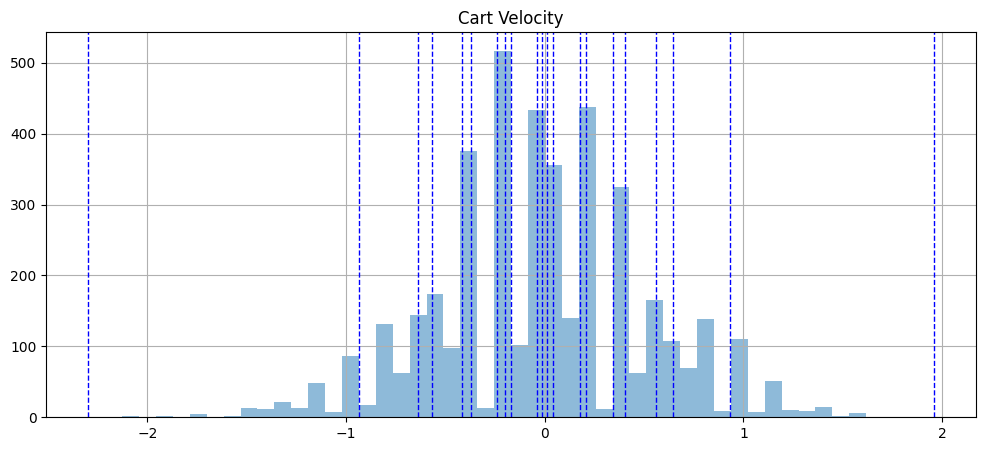

In [103]:
plt.figure(figsize=(12,5))
plt.hist(df[CART_VEL], bins=50, alpha=0.5, label=CART_VEL)

# add quantiles
plt.axvline(df[CART_VEL].quantile(0.0), color='b', linestyle='dashed', linewidth=1, label="0%")
plt.axvline(df[CART_VEL].quantile(0.05), color='b', linestyle='dashed', linewidth=1, label="5%")
plt.axvline(df[CART_VEL].quantile(0.10), color='b', linestyle='dashed', linewidth=1, label="10%")
plt.axvline(df[CART_VEL].quantile(0.15), color='b', linestyle='dashed', linewidth=1, label="15%")
plt.axvline(df[CART_VEL].quantile(0.20), color='b', linestyle='dashed', linewidth=1, label="20%")
plt.axvline(df[CART_VEL].quantile(0.25), color='b', linestyle='dashed', linewidth=1, label="25%")
plt.axvline(df[CART_VEL].quantile(0.30), color='b', linestyle='dashed', linewidth=1, label="30%")
plt.axvline(df[CART_VEL].quantile(0.35), color='b', linestyle='dashed', linewidth=1, label="35%")
plt.axvline(df[CART_VEL].quantile(0.40), color='b', linestyle='dashed', linewidth=1, label="40%")
plt.axvline(df[CART_VEL].quantile(0.45), color='b', linestyle='dashed', linewidth=1, label="45%")
plt.axvline(df[CART_VEL].quantile(0.50), color='b', linestyle='dashed', linewidth=1, label="50%")
plt.axvline(df[CART_VEL].quantile(0.55), color='b', linestyle='dashed', linewidth=1, label="55%")
plt.axvline(df[CART_VEL].quantile(0.60), color='b', linestyle='dashed', linewidth=1, label="60%")
plt.axvline(df[CART_VEL].quantile(0.65), color='b', linestyle='dashed', linewidth=1, label="65%")
plt.axvline(df[CART_VEL].quantile(0.70), color='b', linestyle='dashed', linewidth=1, label="70%")
plt.axvline(df[CART_VEL].quantile(0.75), color='b', linestyle='dashed', linewidth=1, label="75%")
plt.axvline(df[CART_VEL].quantile(0.80), color='b', linestyle='dashed', linewidth=1, label="80%")
plt.axvline(df[CART_VEL].quantile(0.85), color='b', linestyle='dashed', linewidth=1, label="85%")
plt.axvline(df[CART_VEL].quantile(0.90), color='b', linestyle='dashed', linewidth=1, label="90%")
plt.axvline(df[CART_VEL].quantile(0.95), color='b', linestyle='dashed', linewidth=1, label="95%")
plt.axvline(df[CART_VEL].quantile(1.0), color='b', linestyle='dashed', linewidth=1, label="100%")



plt.grid()
# plt.legend()
plt.title("Cart Velocity")
plt.show()

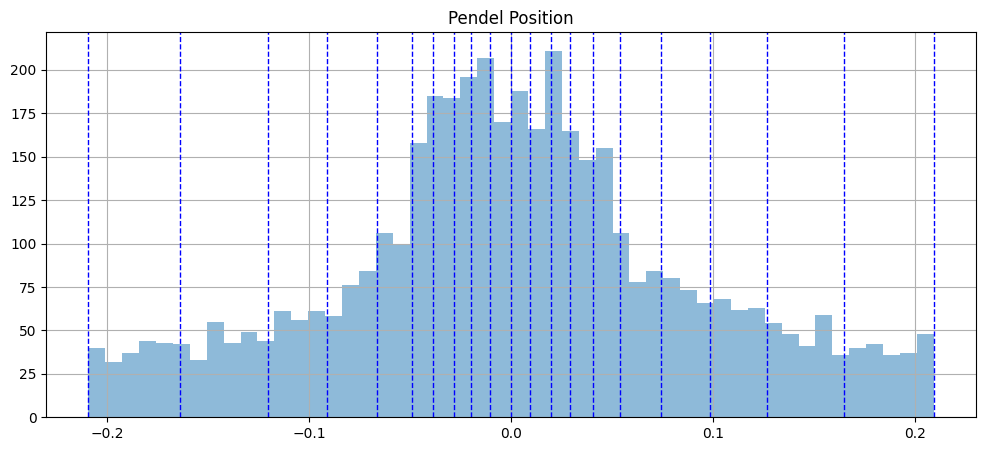

In [104]:
plt.figure(figsize=(12,5))
plt.hist(df[PEND_POS], bins=50, alpha=0.5, label=PEND_POS)

# add quantiles
plt.axvline(df[PEND_POS].quantile(0.0), color='b', linestyle='dashed', linewidth=1, label="0%")
plt.axvline(df[PEND_POS].quantile(0.05), color='b', linestyle='dashed', linewidth=1, label="5%")
plt.axvline(df[PEND_POS].quantile(0.10), color='b', linestyle='dashed', linewidth=1, label="10%")
plt.axvline(df[PEND_POS].quantile(0.15), color='b', linestyle='dashed', linewidth=1, label="15%")
plt.axvline(df[PEND_POS].quantile(0.20), color='b', linestyle='dashed', linewidth=1, label="20%")
plt.axvline(df[PEND_POS].quantile(0.25), color='b', linestyle='dashed', linewidth=1, label="25%")
plt.axvline(df[PEND_POS].quantile(0.30), color='b', linestyle='dashed', linewidth=1, label="30%")
plt.axvline(df[PEND_POS].quantile(0.35), color='b', linestyle='dashed', linewidth=1, label="35%")
plt.axvline(df[PEND_POS].quantile(0.40), color='b', linestyle='dashed', linewidth=1, label="40%")
plt.axvline(df[PEND_POS].quantile(0.45), color='b', linestyle='dashed', linewidth=1, label="45%")
plt.axvline(df[PEND_POS].quantile(0.50), color='b', linestyle='dashed', linewidth=1, label="50%")
plt.axvline(df[PEND_POS].quantile(0.55), color='b', linestyle='dashed', linewidth=1, label="55%")
plt.axvline(df[PEND_POS].quantile(0.60), color='b', linestyle='dashed', linewidth=1, label="60%")
plt.axvline(df[PEND_POS].quantile(0.65), color='b', linestyle='dashed', linewidth=1, label="65%")
plt.axvline(df[PEND_POS].quantile(0.70), color='b', linestyle='dashed', linewidth=1, label="70%")
plt.axvline(df[PEND_POS].quantile(0.75), color='b', linestyle='dashed', linewidth=1, label="75%")
plt.axvline(df[PEND_POS].quantile(0.80), color='b', linestyle='dashed', linewidth=1, label="80%")
plt.axvline(df[PEND_POS].quantile(0.85), color='b', linestyle='dashed', linewidth=1, label="85%")
plt.axvline(df[PEND_POS].quantile(0.90), color='b', linestyle='dashed', linewidth=1, label="90%")
plt.axvline(df[PEND_POS].quantile(0.95), color='b', linestyle='dashed', linewidth=1, label="95%")
plt.axvline(df[PEND_POS].quantile(1.0), color='b', linestyle='dashed', linewidth=1, label="100%")



plt.grid()
# plt.legend()
plt.title("Pendel Position")
plt.show()

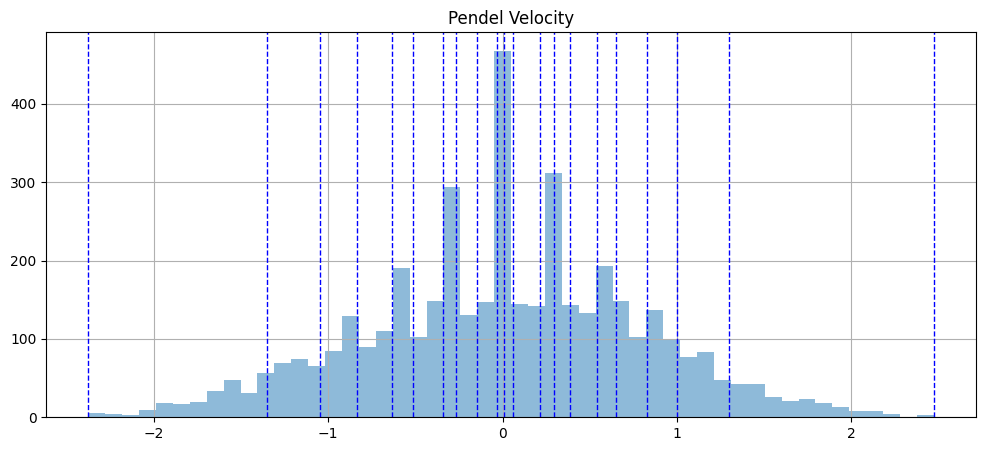

In [105]:
plt.figure(figsize=(12,5))
plt.hist(df[PEND_VEL], bins=50, alpha=0.5, label=PEND_VEL)

# add quantiles
plt.axvline(df[PEND_VEL].quantile(0.0), color='b', linestyle='dashed', linewidth=1, label="0%")
plt.axvline(df[PEND_VEL].quantile(0.05), color='b', linestyle='dashed', linewidth=1, label="5%")
plt.axvline(df[PEND_VEL].quantile(0.10), color='b', linestyle='dashed', linewidth=1, label="10%")
plt.axvline(df[PEND_VEL].quantile(0.15), color='b', linestyle='dashed', linewidth=1, label="15%")
plt.axvline(df[PEND_VEL].quantile(0.20), color='b', linestyle='dashed', linewidth=1, label="20%")
plt.axvline(df[PEND_VEL].quantile(0.25), color='b', linestyle='dashed', linewidth=1, label="25%")
plt.axvline(df[PEND_VEL].quantile(0.30), color='b', linestyle='dashed', linewidth=1, label="30%")
plt.axvline(df[PEND_VEL].quantile(0.35), color='b', linestyle='dashed', linewidth=1, label="35%")
plt.axvline(df[PEND_VEL].quantile(0.40), color='b', linestyle='dashed', linewidth=1, label="40%")
plt.axvline(df[PEND_VEL].quantile(0.45), color='b', linestyle='dashed', linewidth=1, label="45%")
plt.axvline(df[PEND_VEL].quantile(0.50), color='b', linestyle='dashed', linewidth=1, label="50%")
plt.axvline(df[PEND_VEL].quantile(0.55), color='b', linestyle='dashed', linewidth=1, label="55%")
plt.axvline(df[PEND_VEL].quantile(0.60), color='b', linestyle='dashed', linewidth=1, label="60%")
plt.axvline(df[PEND_VEL].quantile(0.65), color='b', linestyle='dashed', linewidth=1, label="65%")
plt.axvline(df[PEND_VEL].quantile(0.70), color='b', linestyle='dashed', linewidth=1, label="70%")
plt.axvline(df[PEND_VEL].quantile(0.75), color='b', linestyle='dashed', linewidth=1, label="75%")
plt.axvline(df[PEND_VEL].quantile(0.80), color='b', linestyle='dashed', linewidth=1, label="80%")
plt.axvline(df[PEND_VEL].quantile(0.85), color='b', linestyle='dashed', linewidth=1, label="85%")
plt.axvline(df[PEND_VEL].quantile(0.90), color='b', linestyle='dashed', linewidth=1, label="90%")
plt.axvline(df[PEND_VEL].quantile(0.95), color='b', linestyle='dashed', linewidth=1, label="95%")
plt.axvline(df[PEND_VEL].quantile(1.0), color='b', linestyle='dashed', linewidth=1, label="100%")



plt.grid()
# plt.legend()
plt.title("Pendel Velocity")
plt.show()

In [96]:
def create_feature_token(feature_name, input):
    if input < df[feature_name].quantile(0.05):
        return 0
    elif input < df[feature_name].quantile(0.10):
        return 1
    elif input < df[feature_name].quantile(0.15):
        return 2
    elif input < df[feature_name].quantile(0.20):
        return 3
    elif input < df[feature_name].quantile(0.25):
        return 4
    elif input < df[feature_name].quantile(0.30):
        return 5
    elif input < df[feature_name].quantile(0.35):
        return 6
    elif input < df[feature_name].quantile(0.40):
        return 7
    elif input < df[feature_name].quantile(0.45):
        return 8
    elif input < df[feature_name].quantile(0.50):
        return 9
    elif input < df[feature_name].quantile(0.55):
        return 10
    elif input < df[feature_name].quantile(0.60):
        return 11
    elif input < df[feature_name].quantile(0.65):
        return 12
    elif input < df[feature_name].quantile(0.70):
        return 13
    elif input < df[feature_name].quantile(0.75):
        return 14
    elif input < df[feature_name].quantile(0.80):
        return 15
    elif input < df[feature_name].quantile(0.85):
        return 16
    elif input < df[feature_name].quantile(0.90):
        return 17
    elif input < df[feature_name].quantile(0.95):
        return 18
    else:
        return 19
    
def create_cart_pos_token(input):
    return create_feature_token(CART_POS, input)

def create_cart_vel_token(input):
    return create_feature_token(CART_VEL, input)

def create_pend_pos_token(input):
    return create_feature_token(PEND_POS, input)

def create_pend_vel_token(input):
    return create_feature_token(PEND_VEL, input)

# GENERATE PATTERN DATA

In [42]:
#############################################
#### HELPER FUNCTIONS FOR PATTERN GENERATION
#############################################
def create_training_data(data, input_col, target_col, window_size=1, training_pattern_percent=0.7):

    data_train = data

    mean_in, std_in = mean_and_std(input_col, data_train)
    mean_out, std_out = mean_and_std(target_col, data_train)
    #data_plot.plot_hist_df(data_train, input_col)
    #data_plot.plot_timeseries_df(data_train, input_col)
    print(f"mean in = {mean_in}" )
    print(f"std in = {std_in}")
    print(f"mean out =  {mean_out}")
    print(f"std out = {std_out}")

    grouped = data_train.groupby(['episode'])

    inputs_all = []
    labels_all = []

    for g in grouped:
        # be sure that data inside a group is not shuffled # not sure if needed
        g = g[1].sort_values(by='step')

        past_history = window_size   # t-3, t-2, t-1, t
        future_target = 0  # t+1
        STEP = 1 # no subsampling of rows in data, e.g. only every i'th row

        # use pandas.DataFrame.values in order to get an numpy array from an pandas.DataFrame object

        inputs, labels = multivariate_data(dataset=g[input_col][:].values, target=g[target_col][:].values,
                                        start_index=0, end_index=g[input_col][:].values.shape[0]-future_target,
                                        history_size=past_history, target_size=future_target, step=STEP,
                                        single_step=True)

        ## Append data to whole set of patterns
        for i in range (0, len(inputs)):
            inputs_all.append(inputs[i])
            labels_all.append(labels[i])
  
    length = len(inputs_all)

    c = list(zip(inputs_all, labels_all))
    np.random.shuffle(c)
    inputs_all, labels_all = zip(*c)

    split = int(training_pattern_percent * length)

    inputs_all = np.array(inputs_all)
    labels_all = np.array(labels_all)

    return ((inputs_all[0:split], labels_all[0:split]), (inputs_all[split:], labels_all[split:])), mean_in, std_in, mean_out, std_out


def mean_and_std(columns, data):
    mean = np.zeros(len(columns))
    std = np.zeros(len(columns))
    index = 0
    for c in columns:
        mean[index], std[index] = get_normalizations(data[c])
        index = index + 1
    return mean, std

def get_normalizations(data):
    mean = data.mean()
    std = data.std()
    return mean, std

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
       end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data, dtype=np.float32), np.array(labels, dtype=np.float32)



def prepare_data(df, input_col, target_col, window_size, training_batch_size=50, validation_batch_size=50, training_pattern_percent=0.7):
    
    global x_train_multi, y_train_multi
    
    ###################
    ## PREPARE DATASET
    ###################
    ((x_train_multi, y_train_multi), (x_val_multi, y_val_multi)), mean_in, std_in, mean_out, std_out = \
                                    create_training_data(df, input_col, target_col, window_size=window_size,
                                                        training_pattern_percent=training_pattern_percent)

    print('trainData: Single window of past history : {}'.format(x_train_multi[0].shape))
    print('trainData: Single window of future : {}'.format(y_train_multi[1].shape))
    print('valData: Single window of past history : {}'.format(x_val_multi[0].shape))
    print('valData: Single window of future : {}'.format(y_val_multi[1].shape))
    print('trainData: number of trainingsexamples: {}'.format(x_train_multi.shape))
    print('valData: number of trainingsexamples: {}'.format(x_val_multi.shape))

    train_data = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
    #train_data = train_data.cache().shuffle(max_training_pattern).batch(training_batch_size).repeat()
    train_data = train_data.shuffle(x_train_multi.shape[0]).batch(training_batch_size).repeat()

    val_data = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
    val_data = val_data.batch(validation_batch_size).repeat()
    input_shape = x_train_multi[0].shape[-2:]
    return train_data, val_data, input_shape, mean_in, std_in, mean_out, std_out


In [43]:
window_size=4
input_col = [CART_POS, CART_VEL, PEND_POS, PEND_VEL, ACTION]
target_col = [CART_POS, CART_VEL, PEND_POS, PEND_VEL]

train_data, val_data, input_shape, mean_in, std_in, mean_out, std_out =  \
            prepare_data(df, input_col, target_col, window_size=window_size, training_pattern_percent=0.7)

print ("Input-Shape: ", input_shape)

mean in = [ 0.0097891   0.03832578 -0.01456913 -0.09250097  0.51201306]
std in = [0.08331749 0.54657034 0.09121294 0.80438516 0.49991397]
mean out =  [ 0.0097891   0.03832578 -0.01456913 -0.09250097]
std out = [0.08331749 0.54657034 0.09121294 0.80438516]
trainData: Single window of past history : (4, 5)
trainData: Single window of future : (4,)
valData: Single window of past history : (4, 5)
valData: Single window of future : (4,)
trainData: number of trainingsexamples: (2440, 4, 5)
valData: number of trainingsexamples: (1047, 4, 5)
Input-Shape:  (4, 5)


# Create Transformer Model

In [44]:
# Ensure TensorFlow 1.15.5 is used
assert tf.__version__ == '1.15.5'

In [45]:

# Transformer Parameters
num_layers = 2
d_model = 128
num_heads = 8
dff = 512
input_shape = (50, 4, 5)

In [46]:
# Positional Encoding
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

pos_encoding = positional_encoding(50, d_model)


In [47]:
# Scaled Dot-Product Attention
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
    
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    
    output = tf.matmul(attention_weights, v)
    return output, attention_weights

# Multi-Head Attention Layer
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        
        output = self.dense(concat_attention)
        
        return output, attention_weights

In [48]:
# Pointwise Feed Forward Network
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

# Encoder Layer
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        
        return out2

# Encoder
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_shape, rate=0.1):
        super(Encoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = tf.keras.layers.Dense(d_model)
        self.pos_encoding = positional_encoding(input_shape[0], d_model)
        
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]
        
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        
        return x

# Time Series Transformer Model
class TimeSeriesTransformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_shape, rate=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_shape, rate)
        self.final_layer = tf.keras.layers.Dense(1)
        
    def call(self, x, training=False):
        mask = None  # Implement masking logic here if needed
        enc_output = self.encoder(x, training, mask)
        final_output = self.final_layer(enc_output)
        final_output = tf.squeeze(final_output, axis=-1)
        return final_output

In [49]:

# Define model parameters
modelpath = "transformer_model"
max_epochs = 1000
steps_per_epoch = 100
validation_steps = 100
validation_freq = 1

# Define callbacks
es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True, verbose=1)
mc_trainLoss_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"{modelpath}.bestTrainLoss", monitor='loss', verbose=1, save_best_only=True, mode='min')
mc_valLoss_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"{modelpath}.bestValLoss", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=r"./model_logs_tb", histogram_freq=1)

# Ensure your model is defined
model = TimeSeriesTransformer(num_layers, d_model, num_heads, dff, input_shape)
model.compile(optimizer='adam', loss='mse')

# Fit the model
history = model.fit(
    train_data,
    epochs=max_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_data,
    validation_steps=validation_steps,
    validation_freq=validation_freq,
    callbacks=[mc_trainLoss_callback, mc_valLoss_callback, es_callback, tensorboard_callback]
)

# Save the model
model.save(modelpath, save_format='tf')


Train for 100 steps, validate for 100 steps
Epoch 1/1000
  7/100 [=>............................] - ETA: 1:08 - loss: 4.6438

2024-07-29 16:38:42.912699: I tensorflow/core/profiler/lib/profiler_session.cc:205] Profiler session started.


 97/100 [============================>.] - ETA: 0s - loss: 0.6965
Epoch 00001: loss improved from inf to 0.68424, saving model to transformer_model.bestTrainLoss

Epoch 00001: val_loss improved from inf to 0.25214, saving model to transformer_model.bestValLoss
100/100 [==============================] - 9s 87ms/step - loss: 0.6826 - val_loss: 0.2521
Epoch 2/1000
 97/100 [============================>.] - ETA: 0s - loss: 0.2547
Epoch 00002: loss improved from 0.68424 to 0.25348, saving model to transformer_model.bestTrainLoss

Epoch 00002: val_loss improved from 0.25214 to 0.19011, saving model to transformer_model.bestValLoss
100/100 [==============================] - 3s 30ms/step - loss: 0.2535 - val_loss: 0.1901
Epoch 3/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1732
Epoch 00003: loss improved from 0.25348 to 0.17247, saving model to transformer_model.bestTrainLoss

Epoch 00003: val_loss improved from 0.19011 to 0.07528, saving model to transformer_model.bestVal

# Evaluate model quality

### Sample new data from environment and determine episode with most steps

In [50]:
dfEval = sample_data(episodes=100, seed=111)
dfEval.describe()
row_max_steps = dfEval[dfEval.step == dfEval.step.max()]
dfEval = dfEval[dfEval.episode==int(row_max_steps.episode)]

### Extract prediction bounds from training data

In [51]:
output_min = y_train_multi.min(axis=0)
output_max = y_train_multi.max(axis=0)
print ("min(output)_data: ", output_min)
print ("max(output)_data: ", output_max)

min(output)_data:  [-0.57179314 -1.8019528  -0.20941441 -2.5872033 ]
max(output)_data:  [0.4655092  2.3208382  0.20845649 2.7470975 ]


### Evaluate transformer

In [52]:
import collections


# Define custom objects dictionary
custom_objects = {
    'TimeSeriesTransformer': TimeSeriesTransformer,
    'Encoder': Encoder,
    'EncoderLayer': EncoderLayer,
    'MultiHeadAttention': MultiHeadAttention,
    'point_wise_feed_forward_network': point_wise_feed_forward_network
}

# Load the saved model with custom objects
modelpath = "transformer_model"
transformer_model = tf.keras.models.load_model(modelpath, custom_objects=custom_objects)
lstm_model = tf.keras.models.load_model("model.h5")

In [53]:
# FIFO-buffer that keeps the neural state
stateBuffer = collections.deque(maxlen=window_size)

# outputs of neural network will be stored here
transitions = []

for i in range (len(dfEval)): 
                            
    # estimation of first state
    if i < window_size: 
        state_data = np.float32([dfEval[CART_POS].values[i], dfEval[CART_VEL].values[i],
                               dfEval[PEND_POS].values[i], dfEval[PEND_VEL].values[i],
                               dfEval[ACTION].values[i]])
        stateBuffer.append(state_data)
        #print ("Filling initState: %s" % state_data)
    
    # predict successor state
    else: 
        
        ###########################
        # recall of neural network
        ###########################
        state = np.array([list(stateBuffer)])
        if i==5:
            print (state)
        
        netOutput = transformer_model.predict(np.float32(state))[0]
        
        # clip output to observed data bounds
        netOutput = np.clip(netOutput, output_min, output_max)
        
        # check if value bound was hit
        if np.any(netOutput == output_min) or np.any(netOutput == output_max):
            print ("Bound-hit at step: ", i, " => terminating further evaluation")
            break
        
        # append plotting data
        transitions.append ({
            CART_POS:netOutput[0], CART_VEL:netOutput[1],
            PEND_POS:netOutput[2], PEND_VEL:netOutput[3]
        })
        
        # update RNN state
        stateBuffer.append(np.float32([netOutput[0], netOutput[1], 
                                       netOutput[2], netOutput[3], 
                                       dfEval[ACTION].values[i]]))
        
transformer_dfNet = pd.DataFrame(transitions)

[[[ 0.0291335   0.15279053  0.00149714 -0.31140706  1.        ]
  [ 0.03218931  0.34789112 -0.00473101 -0.6036174   1.        ]
  [ 0.03914713  0.5430789  -0.01680335 -0.8977868   0.        ]
  [ 0.05220553  0.3513985  -0.04990896 -0.6020913   0.        ]]]
Bound-hit at step:  22  => terminating further evaluation


In [57]:
# FIFO-buffer that keeps the neural state
stateBuffer = collections.deque(maxlen=window_size)

# outputs of neural network will be stored here
transitions = []

for i in range (len(dfEval)): 
                            
    # estimation of first state
    if i < window_size: 
        state_data = np.float32([dfEval[CART_POS].values[i], dfEval[CART_VEL].values[i],
                               dfEval[PEND_POS].values[i], dfEval[PEND_VEL].values[i],
                               dfEval[ACTION].values[i]])
        stateBuffer.append(state_data)
        #print ("Filling initState: %s" % state_data)
    
    # predict successor state
    else: 
        
        ###########################
        # recall of neural network
        ###########################
        state = np.array([list(stateBuffer)])
        if i==5:
            print (state)
        
        netOutput = lstm_model.predict(np.float32(state))[0]
        
        # clip output to observed data bounds
        netOutput = np.clip(netOutput, output_min, output_max)
        
        # check if value bound was hit
        if np.any(netOutput == output_min) or np.any(netOutput == output_max):
            print ("Bound-hit at step: ", i, " => terminating further evaluation")
            break
        
        # append plotting data
        transitions.append ({
            CART_POS:netOutput[0], CART_VEL:netOutput[1],
            PEND_POS:netOutput[2], PEND_VEL:netOutput[3]
        })
        
        # update RNN state
        stateBuffer.append(np.float32([netOutput[0], netOutput[1], 
                                       netOutput[2], netOutput[3], 
                                       dfEval[ACTION].values[i]]))
        
lstm_dfNet = pd.DataFrame(transitions)

[[[ 0.0291335   0.15279053  0.00149714 -0.31140706  1.        ]
  [ 0.03218931  0.34789112 -0.00473101 -0.6036174   1.        ]
  [ 0.03914713  0.5430789  -0.01680335 -0.8977868   0.        ]
  [ 0.05056916  0.34876472 -0.03546108 -0.61091274  0.        ]]]


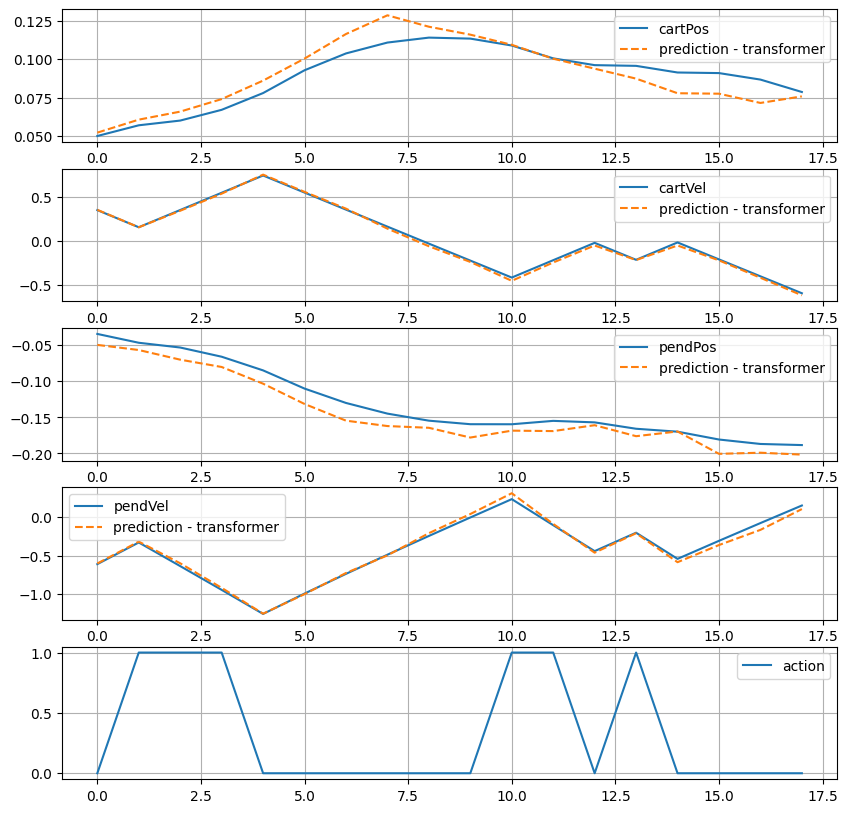

In [61]:
fig, axs = plt.subplots (5, 1, figsize=(10,10))

fields = [CART_POS, CART_VEL, PEND_POS, PEND_VEL]

for i in range (len(fields)):
    f = fields[i]
    axs[i].plot(range (len(transformer_dfNet)), dfEval[f].values[window_size:window_size+len(transformer_dfNet)], label=f)
    axs[i].plot(range (len(transformer_dfNet)), transformer_dfNet[f].values, label="prediction - transformer", ls="--")
    axs[i].grid()
    axs[i].legend(loc="best")
    
axs[4].plot(range (len(transformer_dfNet)), dfEval[ACTION].values[window_size:window_size+len(transformer_dfNet)], label=ACTION)
axs[4].grid()
axs[4].legend(loc="best")

plt.show()

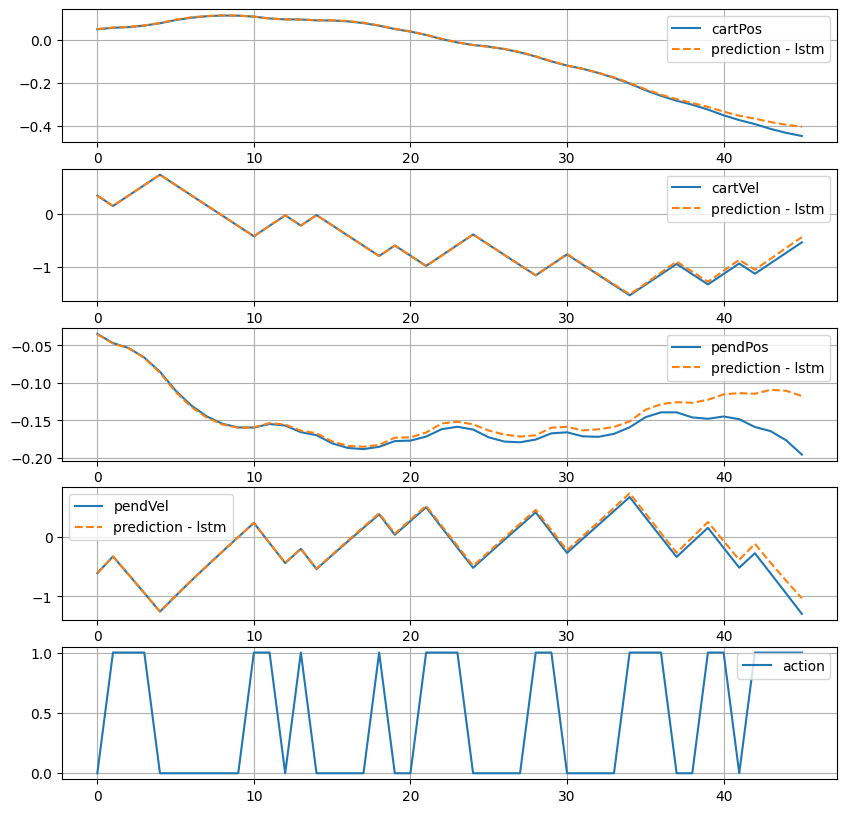

In [65]:
fig, axs = plt.subplots (5, 1, figsize=(10,10))

fields = [CART_POS, CART_VEL, PEND_POS, PEND_VEL]

for i in range (len(fields)):
    f = fields[i]
    axs[i].plot(range (len(lstm_dfNet)), dfEval[f].values[window_size:window_size+len(lstm_dfNet)], label=f)
    axs[i].plot(range (len(lstm_dfNet)), lstm_dfNet[f].values, label="prediction - lstm", ls="--")
    axs[i].grid()
    axs[i].legend(loc="best")
    
axs[4].plot(range (len(lstm_dfNet)), dfEval[ACTION].values[window_size:window_size+len(lstm_dfNet)], label=ACTION)
axs[4].grid()
axs[4].legend(loc="best")

plt.show()